In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.models as models
import copy

In [2]:
# Configure the device gpu is required for faster 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
IMG_SIZE = 1000
CONTENT_WEIGHT = 5e0
STYLE_WEIGHT = 1e2
TV_WEIGHT = 1e-3

In [4]:
def imshow(tensor, title):
    unloader = transforms.ToPILImage()
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    if title is not None:
        plt.title(title)
    plt.imshow(image)
    plt.show()

In [5]:
def load_img(filename):
    preprocess_t = transforms.Compose([transforms.Resize(IMG_SIZE),
                                       transforms.ToTensor()])
    image = Image.open(filename)
    image = preprocess_t(image).unsqueeze(0)
    return image.to(device, torch.float)

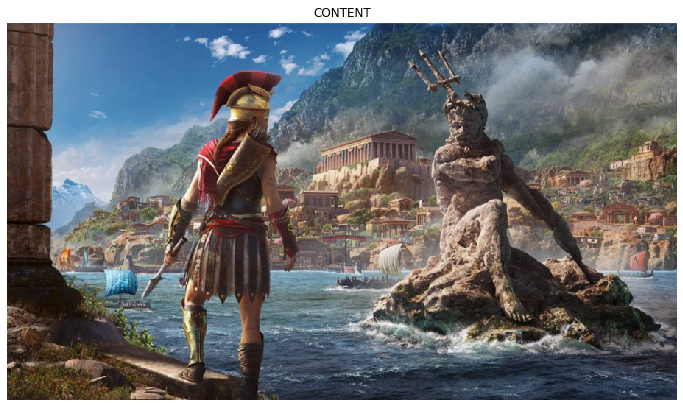

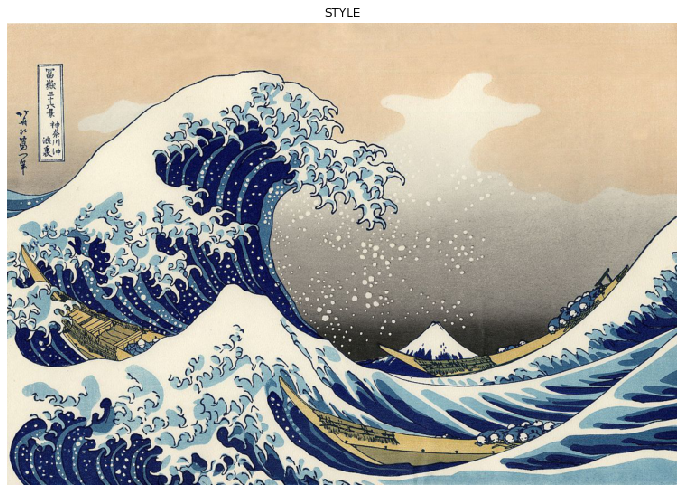

In [6]:
content_img = load_img("./data/images/content2.jpg")
style_img = load_img("./data/images/content2.jpg")

plt.figure(figsize = (12, 12))
plt.axis("off")
imshow(content_img, title = "CONTENT")

plt.figure(figsize = (12, 12))
plt.axis("off")
imshow(style_img, title = "STYLE")

In [7]:
# lOAD THE MODEL FROM WHERE WE DERIVE ALL THE FEATURES
vgg19 = models.vgg19(pretrained=True)

# CHANGE POOLING
def pool_(model , pool = "avg"):
    if (pool == 'avg'):
        ct = 0
        for layer in model.children():
            if isinstance(layer, nn.MaxPool2d):
                model[ct] = nn.AvgPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=False)
                ct+=1
    elif (pool == "max"):
        ct = 0
        for layer in model.children():
            if isinstance(layer, nn.MaxPool2d):
                model[ct] = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, ceil_mode=False)
                ct+=1
    return model



model = copy.deepcopy(vgg19.features)
model.to(device)

for param in model.parameters():
    param.requires_grad = False

In [8]:
def gram_matrix(tensor):
    # Example tenor size :  (1, 256, 56, 56)
    a, b, c, d = tensor.size()
    x = tensor.view(a * b, c * d)
    # shape : (256, 3136)
    G = torch.mm(x, x.t())
    return G.div(a * b * c * d)

mse_loss = torch.nn.MSELoss()
def ContentLoss(content, target):
    loss = mse_loss(content, target)
    return loss

def StyleLoss(style, target):
    loss = mse_loss(style, target)
    return loss

def tv_loss(c):
    x = c[:,:,1:,:] - c[:,:,:-1,:]
    y = c[:,:,:,1:] - c[:,:,:,:-1]
    loss = torch.sum(torch.abs(x)) + torch.sum(torch.abs(y))
    return loss

In [9]:
for name, layer in vgg19._modules.items():
    print(name)
    print(layer)

features
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18

In [10]:
def get_features(model, tensor):
    layers = {
        '3': 'relu1_2',   # Style layers
        '8': 'relu2_2',
        '17' : 'relu3_3',
        '26' : 'relu4_3',
        '35' : 'relu5_3',
        '22' : 'relu4_2', # Content layers
        #'31' : 'relu5_2'
    }
    features = {}
    x = tensor
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            if (name == "22"):
                features[layers[name]] = x
            elif (name == "31"):
                features[layers[name]] = x
            else:
                a, b, c, d = x.size()
                features[layers[name]] = gram_matrix(x)
            if (name == "35"):
                break
    return features

In [11]:
def noise_image(content_img):
    a, b, c, d = content_img.size()
    tensor = torch.randn((b, c, d)).unsqueeze(0)
    return tensor

cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

def normalize(content, style):
    mean = cnn_normalization_mean.view(-1, 1, 1)
    std = cnn_normalization_std.view(-1, 1, 1)
    content = (content - mean) / std
    style = (style - mean) / std
    return content, style


content_img, style_img = normalize(content_img, style_img)
content_img, style_img = content_img.to(device), style_img.to(device)

In [12]:
noise_input = noise_image(content_img)
noise_input = noise_input.to(device).requires_grad_(True)
print(noise_input.size())

torch.Size([1, 3, 512, 910])


In [13]:
optimizer = optim.Adam([noise_input], lr=10)

In [14]:
def run_style_transfer(EPOCHS):
    content_layers = ['relu4_2']
    content_weights = {'relu4_2': 1.0} 
    style_layers = ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3', 'relu5_3']
    style_weights = {'relu1_2': 0.2, 'relu2_2': 0.2, 'relu3_3': 0.2, 'relu4_3': 0.2, 'relu5_3': 0.2}
    c_feat = get_features(model, content_img)
    s_feat = get_features(model, style_img)
    i = [0]
    while i[0] < EPOCHS:
        def train_step():
            optimizer.step()
            g_feat = get_features(model, noise_input)
            c_loss = 0
            s_loss = 0
            for k in content_layers:
                c_loss += content_weights[k] * ContentLoss(g_feat[k], c_feat[k])
            for m in style_layers:
                s_loss += style_weights[m] * StyleLoss(g_feat[m], s_feat[m])
            
            c_loss = CONTENT_WEIGHT * c_loss
            s_loss = STYLE_WEIGHT * s_loss
            t_loss = TV_WEIGHT * tv_loss(noise_input.clone().detach())
            total_loss = c_loss + s_loss + t_loss
            
            total_loss.backward(retain_graph = True)
            i[0]+=1
            if (i[0] % 50 == 0):
                print("EPOCH %d" % (i[0]))
                print("StyleLoss: %.3f ContentLoss : %.3f TVLoss : %.3f" % (s_loss.item(), c_loss.item(), t_loss.item()))
                s = noise_input.size()
                plt.figure(figsize = (10, 10))
                imshow(noise_input.clone().detach(), "lol")
            return total_loss
        
        optimizer.step(train_step)
    return noise_input

EPOCH 50
StyleLoss: 538289152.000 ContentLoss : 806394.500 TVLoss : 530213.500


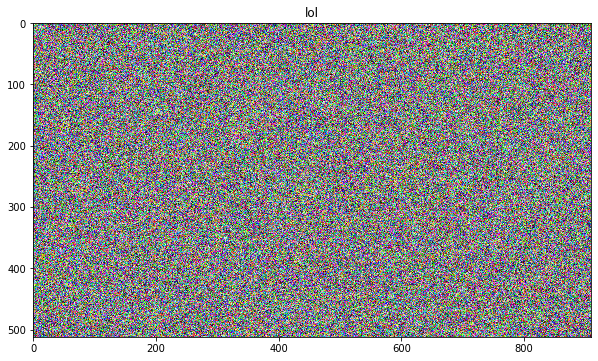

EPOCH 100
StyleLoss: 7625917440.000 ContentLoss : 3425874.000 TVLoss : 1182354.250


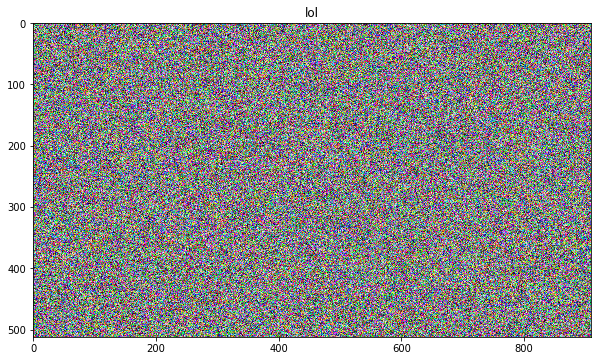

EPOCH 150
StyleLoss: 29703962624.000 ContentLoss : 7137216.000 TVLoss : 1874505.250


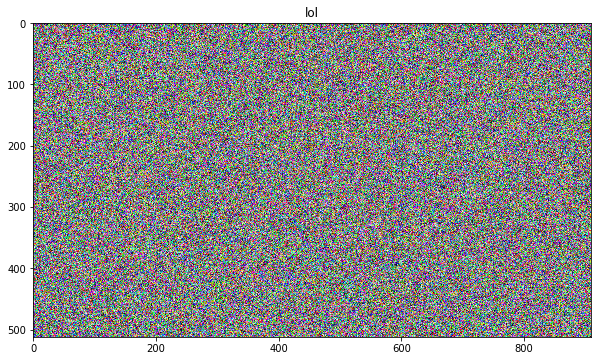

EPOCH 200
StyleLoss: 79677407232.000 ContentLoss : 12140921.000 TVLoss : 2549151.000


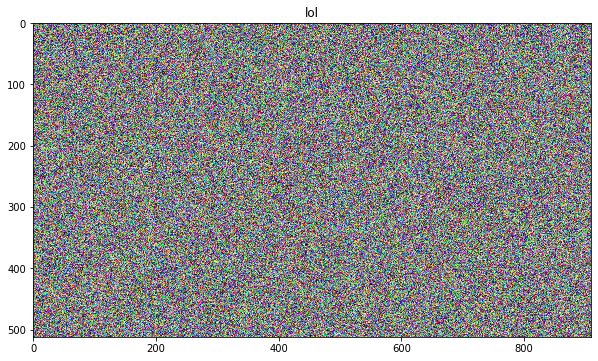

EPOCH 250
StyleLoss: 105045917696.000 ContentLoss : 14660438.000 TVLoss : 3132242.750


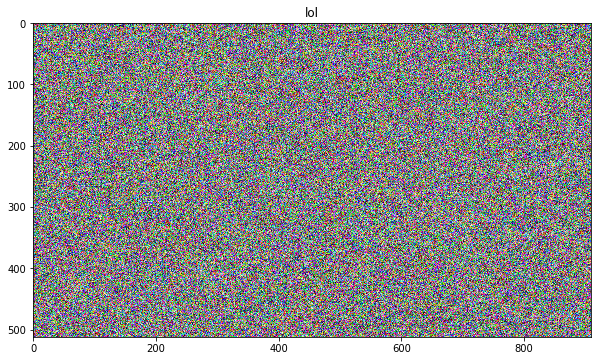

EPOCH 300
StyleLoss: 146630180864.000 ContentLoss : 17622008.000 TVLoss : 3670390.500


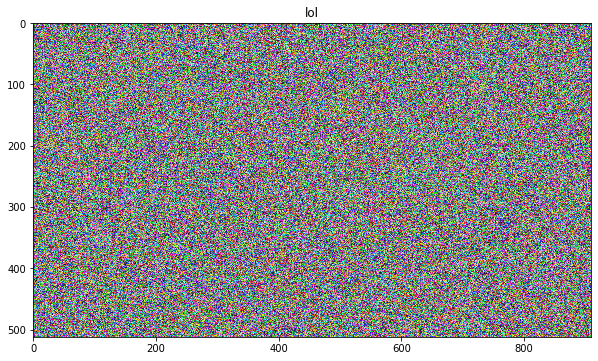

tensor([[[[ -942.3770,   854.4175,  2424.3003,  ...,  -143.4328,
            -937.4630,  1138.3500],
          [ 1573.2522, -2438.4028, -2713.4153,  ..., -1355.0128,
           -3654.4905, -2405.0569],
          [ 1695.5707,   968.8252, -1497.8352,  ...,   919.2235,
            -312.7601,  -887.0416],
          ...,
          [-1338.9381, -2913.5281, -2809.2905,  ..., -1719.0249,
           -1527.7153, -2205.9836],
          [ 1450.6554,  2323.4504,  2687.8120,  ..., -1108.4386,
           -1364.0852,  -841.1799],
          [ -892.8557,  -455.0392, -1392.3291,  ...,  -148.6668,
            -990.6769, -1324.9287]],

         [[  726.8146,  -375.6366,   408.1060,  ...,  -154.3132,
             920.7542,  1728.0220],
          [  744.5356,   805.0203,  -412.9041,  ...,  -279.3996,
             996.6956,   -34.7753],
          [ 1820.4974,  1077.0515,  -772.3267,  ...,  -290.5388,
           -1119.3124,   624.8537],
          ...,
          [ 1064.9418,   859.3019,  1248.2128,  ...,  1910.

In [15]:
run_style_transfer(300)